# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os
import torch
import time
import torchvision
from torch import nn
from torch import optim
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from collections import OrderedDict
import json


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Define your transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
trainset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
testset =  torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)
validset = torchvision.datasets.ImageFolder(valid_dir, transform=valid_transforms)

image_datasets = {}
image_datasets['train'] = trainset
image_datasets['test'] = testset
image_datasets['valid'] = validset

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True)
               for x in ['train','valid', 'test']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [81]:
# create dict --> 21 : fire lily
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# for keys,values in cat_to_name.items():
#     print(keys, values)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [102]:
#Variables

# pick one of the following
arch = 'vgg16'
# arch = 'densenet201'

epochs = 1

In [103]:
# Build and train your network

# Load a pre-trained network (If you need a starting point, the VGG networks work great and are straightforward to 
if arch == "densenet201":
    model = models.densenet201(pretrained=True)
    input_size = model.classifier.in_features
elif arch == 'vgg16':    
    model = models.vgg16(pretrained=True)
    input_size = model.classifier[0].in_features
else:
    print('This model type is supported')
    
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [104]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
if arch == "densenet201":
    # for densenet201
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1920, 1500)),
                              ('drop1', nn.Dropout(p=0.6)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1500, 1000)),
                              ('drop2', nn.Dropout(p=0.6)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(1000, 500)),
                              ('relu', nn.ReLU()),
                              ('fc4', nn.Linear(500, 102)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
elif arch == 'vgg16':
    # for vgg16
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(25088, 1500)),
                              ('drop1', nn.Dropout(p=0.6)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1500, 1000)),
                              ('drop2', nn.Dropout(p=0.6)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(1000, 500)),
                              ('relu', nn.ReLU()),
                              ('fc4', nn.Linear(500, 102)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
else:
    print('This model type is supported')
    
model.classifier = classifier

# Train the classifier layers using backpropagation using the pre-trained network to get the features
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [105]:
# Use cuda if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
        if True:
            images, labels = images.to('cuda'), labels.to('cuda')
        else:
            images, labels = images.data.cpu(), labels.data.cpu()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [107]:
model.to('cuda');
def check_accuracy_on_test(testloader):  
    print('Beginning accuracy test...')
    t1 = time.time()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            print('{}/{}'.format(correct, total));
            images, labels = data
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %d %%' % (100 * correct / total))
    t_total = time.time() - t1;
    print('Accuracy test time: {:.0f}m {:.0f}s'.format(
        t_total // 60, t_total % 60))



In [108]:
def do_deep_learning(model, trainloader, validloader, epochs, print_every, criterion, optimizer, gpu):
    print('\nBeginning deep learning...')
    t1 = time.time()
    steps = 0

    # change to cuda
    if(gpu):
        model.to('cuda')
    else:
        model.to('cpu')

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
            if gpu:
                inputs, labels, criterion = inputs.to('cuda'), labels.to('cuda'), criterion.cuda()
            else:
                inputs, labels = inputs.data.cpu(), labels.data.cpu()

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validloader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                      "Validation Accuracy: {:.1f}%".format(100 * accuracy/len(validloader)))
                running_loss = 0

                # Make sure training is back on
                model.train()

                running_loss = 0
    t_total = time.time() - t1
    print('Train time: {:.0f}m {:.0f}s'.format(
        t_total // 60, t_total % 60)) 

In [109]:
do_deep_learning(model, dataloaders['train'], dataloaders['valid'], epochs, 10, criterion, optimizer, True)                


Beginning deep learning...
Epoch: 1/1..  Training Loss: 4.581..  Validation Loss: 4.459..  Validation Accuracy: 3.6%
Epoch: 1/1..  Training Loss: 4.414..  Validation Loss: 4.294..  Validation Accuracy: 2.6%
Epoch: 1/1..  Training Loss: 4.368..  Validation Loss: 4.113..  Validation Accuracy: 19.8%
Epoch: 1/1..  Training Loss: 4.240..  Validation Loss: 3.922..  Validation Accuracy: 19.5%
Epoch: 1/1..  Training Loss: 4.105..  Validation Loss: 3.714..  Validation Accuracy: 19.9%
Epoch: 1/1..  Training Loss: 3.895..  Validation Loss: 3.471..  Validation Accuracy: 27.2%
Epoch: 1/1..  Training Loss: 3.754..  Validation Loss: 3.263..  Validation Accuracy: 26.9%
Epoch: 1/1..  Training Loss: 3.466..  Validation Loss: 3.002..  Validation Accuracy: 34.5%
Epoch: 1/1..  Training Loss: 3.357..  Validation Loss: 2.749..  Validation Accuracy: 40.9%
Epoch: 1/1..  Training Loss: 3.160..  Validation Loss: 2.532..  Validation Accuracy: 42.7%
Train time: 5m 17s


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [110]:
# Do validation on the training set
check_accuracy_on_test(dataloaders['train'])

# Do validation on the test set
check_accuracy_on_test(dataloaders['test'])

Beginning accuracy test...
0/0
15/64
37/128
59/192
87/256
109/320
128/384
145/448
160/512
185/576
210/640
222/704
246/768
269/832
287/896
310/960
332/1024
350/1088
369/1152
399/1216
420/1280
447/1344
462/1408
489/1472
504/1536
520/1600
537/1664
558/1728
577/1792
599/1856
624/1920
643/1984
664/2048
682/2112
701/2176
724/2240
745/2304
772/2368
793/2432
814/2496
835/2560
856/2624
879/2688
896/2752
918/2816
934/2880
950/2944
971/3008
989/3072
1010/3136
1030/3200
1056/3264
1080/3328
1100/3392
1127/3456
1147/3520
1163/3584
1187/3648
1210/3712
1229/3776
1251/3840
1279/3904
1298/3968
1321/4032
1340/4096
1361/4160
1383/4224
1407/4288
1434/4352
1458/4416
1480/4480
1501/4544
1524/4608
1547/4672
1567/4736
1582/4800
1607/4864
1624/4928
1646/4992
1669/5056
1685/5120
1703/5184
1721/5248
1741/5312
1760/5376
1788/5440
1807/5504
1827/5568
1845/5632
1868/5696
1891/5760
1909/5824
1927/5888
1941/5952
1962/6016
1976/6080
2001/6144
2022/6208
2049/6272
2072/6336
2087/6400
2102/6464
2126/6528
Accuracy of the n

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [111]:
# print("Our model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())

In [112]:
# Create the checkpoint object
checkpoint = {'arch': arch,
              'input_size': input_size,
              'output_size': 102,
              'epochs': epochs,
              'classifier': model.classifier,
              'optimizer_state': optimizer.state_dict(),
              'mapping': image_datasets['train'].class_to_idx,
              'state_dict': model.state_dict()}

# Save the checkpoint 
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [113]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    print('Loading checkpoint...')
    checkpoint = torch.load(filepath)
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
    else: 
        model = models.densenet201(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.optimizer_state = checkpoint['optimizer_state']
    model.mapping = checkpoint['mapping']
    model.load_state_dict(checkpoint['state_dict'])
    print('Done')
    return model

In [114]:
model = load_checkpoint('checkpoint.pth')

Loading checkpoint...
Done


In [115]:
# print("Our model: \n\n", model, '\n')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [116]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    width = int(image.size[0])
    height = int(image.size[1])
    ratio = float(width)/float(height)
    
    if (width > height):
        size = int(256*ratio), int(256) # width, height
    elif (width < height):
        size = int(256), int(256*ratio)
    else:
        size = int(256),int(256)
    
    width, height = size; # reset width & height
    image = image.resize(size)
    
    left = (width - 224)/2
    right = (width + 224)/2
    top = (height - 224)/2
    bottom = (height + 224)/2

    image = image.crop((left, top, right, bottom))
    
    np_image = np.array(image)
    np_image = np_image/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean)/std
                       
    np_image = np_image.transpose((2, 0, 1))                  
    return np_image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [117]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [118]:
# Test image is a hippeastrum
test_image ='/ddl.jpg'

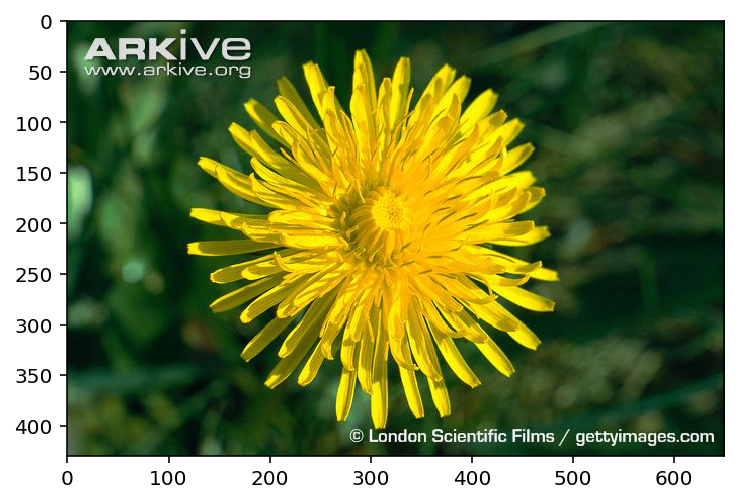

In [119]:
with Image.open(data_dir + test_image) as image:
    plt.imshow(image)

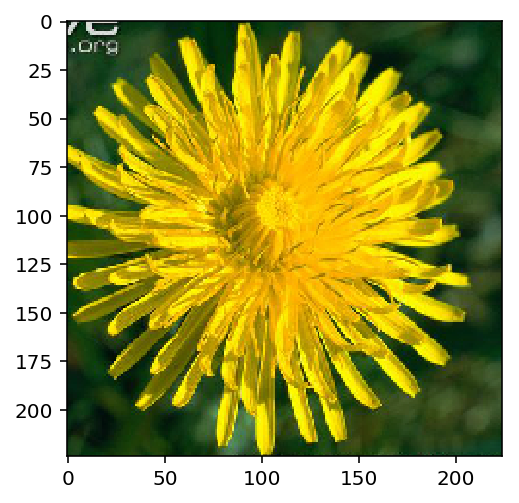

In [120]:
with Image.open(data_dir + test_image) as image:
    image = process_image(image)
    imshow(torch.FloatTensor(image))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [121]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    print('Predicting classification for image...')
    model.eval()
    model.cpu()
    
    # convert from these indices to the actual class labels
    idx_to_class = {i: k for k, i in model.mapping.items()}
    
    # Load and Process Image
    with Image.open(image_path) as image:
        image = process_image(image)

    # Switch it to a float tensor
    image = torch.FloatTensor([image])    
    
    # Feed it through the model
    output = model.forward(image)
    
    # Determine topk probabilities and labels
    topk_prob, topk_labels = torch.topk(output, topk)

    # Take exp() of image to cancel out the LogSoftMax
    topk_prob = topk_prob.exp();

    # Assemble the lists
    topk_prob_arr = topk_prob.data.numpy()[0]
    topk_indexes_list = topk_labels.data.numpy()[0].tolist()
    print('topk_indexes_list', topk_indexes_list)
    print(topk_indexes_list[0])
    
    topk_labels_list = [idx_to_class[x] for x in topk_indexes_list]
    print('topk_labels_list: ', topk_labels_list)
    
    
    topk_class_arr = [cat_to_name[str(x)] for x in topk_labels_list]
    print('topk_prob_arr: ', topk_prob_arr)
    print('topk_class_arr: ', topk_class_arr)
    print('Done')
    
    return topk_prob_arr, topk_class_arr   
    

In [122]:
predict(data_dir + test_image, model, 5);

Predicting classification for image...
topk_indexes_list [48, 6, 38, 46, 71]
48
topk_labels_list:  ['50', '12', '41', '49', '71']
topk_prob_arr:  [ 0.42305681  0.31300953  0.0441294   0.02523216  0.02356532]
topk_class_arr:  ['common dandelion', "colt's foot", 'barbeton daisy', 'oxeye daisy', 'gazania']
Done


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Predicting classification for image...
topk_indexes_list [48, 6, 38, 46, 71]
48
topk_labels_list:  ['50', '12', '41', '49', '71']
topk_prob_arr:  [ 0.42305681  0.31300953  0.0441294   0.02523216  0.02356532]
topk_class_arr:  ['common dandelion', "colt's foot", 'barbeton daisy', 'oxeye daisy', 'gazania']
Done


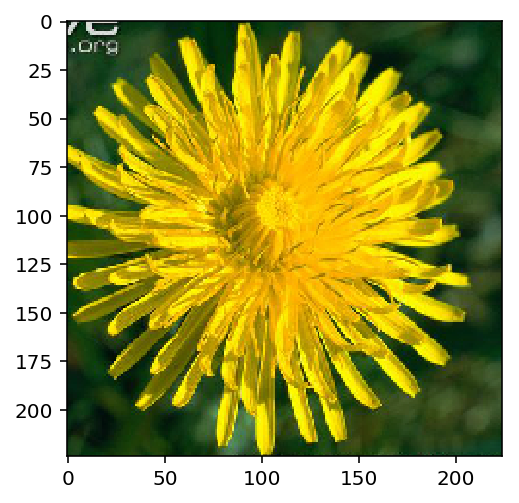

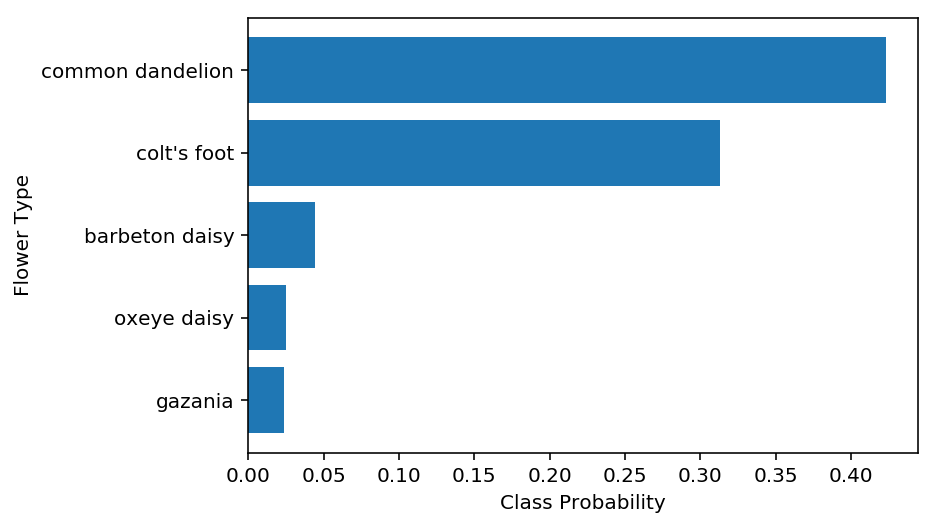

In [123]:
# Display an image along with the top 5 classes
with Image.open(data_dir + test_image) as image:
    image = process_image(image)
    imshow(torch.FloatTensor(image))

classes, probabilities = predict(data_dir + test_image, model, 5);

fig, ax = plt.subplots()
y_pos = np.arange(len(classes))
plt.barh(y_pos, list(reversed(classes)))
plt.yticks(y_pos, list(reversed(probabilities)))
plt.ylabel('Flower Type')
plt.xlabel('Class Probability');